# Stock value prediction from Open, High, Low

# Import module

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import pandas as pd
from pandas import datetime
from pandas import DataFrame
from pandas import concat
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import pandas_datareader.data as web
import h5py
import os
import keras.backend as K
from keras.utils.generic_utils import get_custom_objects

from collections import deque
from io import StringIO

Using TensorFlow backend.


# Input parameters 

In [2]:
stock_name = '^GSPC'
seq_len = 22
d = 0.2
shape = [4, seq_len, 1] # feature, window, output
neurons = [128, 128, 32, 1]
epochs = 200

neurons_layer = 1
optimizer = 'Adam'
loss = 'mse'
action = 'train'
# loss = 'risk_estimation'

# 1. Download data and normalize it
Data since date 'start' to today

In [3]:
def normalize_df(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    for feature in df.columns:
        df[feature] = min_max_scaler.fit_transform(df[feature].values.reshape(-1,1))
    return df

def denormalize(normalized_value):
#     for feature in df.columns:
#         df[feature] = min_max_scaler.fit_transform(df[feature].values.reshape(-1,1))
    
#     min_max_scaler.inverse_transform(normalized_value)
    
#     normalized_value = normalized_value.reshape(-1,1)
    
#     #return df.shape, p.shape
#     min_max_scaler = preprocessing.MinMaxScaler()
#     a = min_max_scaler.fit_transform(df)
#     new = min_max_scaler.inverse_transform(normalized_value)
    return normalized_value

In [4]:
import dateutil.parser
def get_last_date(stock_name):
    data_path = 'data/' + stock_name
    if os.path.exists(data_path):
        with open(data_path, 'r') as f:
            last_day_string = deque(f, 1).pop().split(",")[0]
            start = datetime.datetime.strptime(last_day_string, '%Y-%m-%d') + datetime.timedelta(days=1)
            start = start.date()
            return start
    else:
        return datetime.datetime(2013, 1, 1).date()

def update_stock_data(stock_name):
    start = get_last_date(stock_name)
    end = datetime.date.today()
    data_path = 'data/' + stock_name
    
    if os.path.exists(data_path):
        with open(data_path, 'r') as f:
            last_day_string = deque(f, 1).pop().split(",")[0]
            start = datetime.datetime.strptime(last_day_string, '%Y-%m-%d')
            start = start.date()

    if start > datetime.date.today():
        print ('stock data already latest')
        return
    else:
        try:
            df = web.DataReader(stock_name, "yahoo", start)
        except:
            print('retrying data from yahoo...')
            update_stock_data(stock_name)
            return
        
        if os.path.exists(data_path):
            with open(data_path, 'a') as f:
#                 print('df = ',df, 'start = ', start)
                mask = df.index > str(start)
                df = df[mask]
                df.to_csv(f, header=False)
                print ('stock data appended')
        else:
            df.to_csv(data_path)
            print ('stock data create')
        
                
def get_stock_data(stock_name, normalize=True, use_exist_data=True):
    data_path = 'data/' + stock_name
    df = pd.read_csv(os.path.join(data_path))
    
    df.drop(['Volume', 'Close', 'Date'], 1, inplace=True)
    
    if normalize:
#         df = df
        df = normalize_df(df)
    return df

In [5]:
update_stock_data(stock_name)
df = get_stock_data(stock_name, normalize=True)

stock data appended


# 2. Plot out the Normalized Adjusted close price

In [6]:
def plot_stock(stock_name):
    df = get_stock_data(stock_name, normalize=False)
    print(df.head())
    plt.plot(df['Adj Close'], color='red', label='Adj Close')
    plt.legend(loc='best')
    plt.show()

          Open         High          Low    Adj Close
0  1402.430054  1426.739990  1398.109985  1426.189941
1  1426.189941  1462.430054  1426.189941  1462.420044
2  1462.420044  1465.469971  1455.530029  1459.369995
3  1459.369995  1467.939941  1458.989990  1466.469971
4  1466.469971  1466.469971  1456.619995  1461.890015


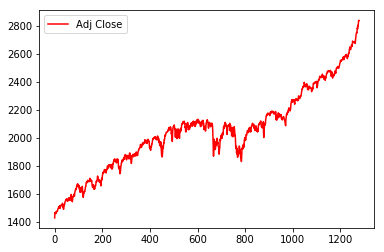

In [7]:
plot_stock(stock_name)

# 3. Set last day Adjusted Close as y

In [8]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split
    
    train = result[:int(row), :] # 90% date
    X_train = train[:, :-1] # all data until day m
    y_train = train[:, -1][:,-1] # day m + 1 adjusted close price
    
    X_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1] 

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test]

In [9]:
X_train, y_train, X_test, y_test = load_data(df, seq_len)

In [10]:
X_train.shape[0], X_train.shape[1], X_train.shape[2]

(1130, 22, 4)

In [11]:
y_train.shape[0]

1130

# 4. Buidling neural network

In [12]:
def build_model2(layers, neurons, d):
    model = Sequential()
    
    for i in range(neurons_layer):
        model.add(LSTM(neurons[0], input_shape=(layers[1], layers[0]), return_sequences=True))
        model.add(Dropout(d))

    model.add(LSTM(neurons[1], input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))
    # model = load_model('my_LSTM_stock_model1000.h5')
    # adam = keras.optimizers.Adam(decay=0.2)
    model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
    model.summary()
    return model

# 6. Model Execution

In [13]:
# model = build_model2(shape, neurons, d)
# # layers = [4, 22, 1]

In [14]:
# model.fit(
#     X_train,
#     y_train,
#     batch_size=512,
#     epochs=epochs,
#     validation_split=0.1,
#     verbose=1)

# 7. Result on training set and testing set

In [15]:
# def model_score(model, X_train, y_train, X_test, y_test):
#     trainScore = model.evaluate(X_train, y_train, verbose=0)
#     print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

#     testScore = model.evaluate(X_test, y_test, verbose=0)
#     print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
#     return trainScore[0], testScore[0]

# model_score(model, X_train, y_train, X_test, y_test)

# 8. Prediction vs Real results

In [16]:
def percentage_difference(model, X_test, y_test):
    percentage_diff=[]

    p = model.predict(X_test)
    for u in range(len(y_test)): # for each data index in test data
        pr = p[u][0] # pr = prediction on day u

        percentage_diff.append((pr-y_test[u]/pr)*100)
    return percentage_diff

In [17]:
# p = percentage_difference(model, X_test, y_test)

# 9. Plot out prediction

In [18]:
def plot_value(stock_name, predict, actual, dir_name, file_name):
    if not os.path.isdir(dir_name):
        os.makedirs(dir_name)
    
    fig_path = dir_name + '/' + file_name
    
    plt2.plot(predict, color='red', label='Prediction')
    plt2.plot(actual,color='blue', label='Actual')
    plt2.legend(loc='best')
    plt2.title('The test result for {}'.format(stock_name))
    plt2.xlabel('Days')
    plt2.ylabel('Adjusted Close')
    plt2.savefig(fig_path, format='png', bbox_inches='tight', transparent=True)
    plt2.close('all')

In [19]:
def plot_result(stock_name, normalized_value_p, normalized_value_y_test, epochs, date):
    newp = denormalize(normalized_value_p)
    newy_test = denormalize(normalized_value_y_test)    
    subdir = '/' +  date.strftime("%Y%m%d%H%M%S") + '/' + 'price' 
    dir_name = str(neurons_layer) + 'layer_' + optimizer + stock_name + subdir 
    figname = stock_name + '_epochs' + str(epochs) + '.png'
    plot_value(stock_name, newp, newy_test, dir_name, figname)

In [20]:
# 損益計算
def plot_value_change_and_revenue(stock_name, normalized_value_p, normalized_value_y_test, epochs, date):
    newp = denormalize(normalized_value_p)
    newy_test = denormalize(normalized_value_y_test)
    
    volumn_change_p = []
    volumn_change_y_test = []
    revenue_p = []
    revenue_y_test = []
    total_revenue_p = []
    total_revenue_y_test = []
    for i in range(len(newp)):
        if i == 0:
            volumn_change_p.append(0)
            volumn_change_y_test.append(0)
            
            revenue_p.append(0)
            revenue_y_test.append(0)
            
            total_revenue_p.append(0)
            total_revenue_y_test.append(0)
        else:
            volumn_change_p.append(newp[i] - newp[i-1])
            volumn_change_y_test.append(newy_test[i] - newy_test[i-1])

            if volumn_change_p[i] > volumn_change_p[i-1]:
                revenue_p.append(volumn_change_y_test[i] - volumn_change_y_test[i - 1])
            else:
                revenue_p.append(volumn_change_y_test[i - 1] - volumn_change_y_test[i])
            
            test_earn = abs(volumn_change_y_test[i] - volumn_change_y_test[i - 1])
            revenue_y_test.append(test_earn)
            
            total_revenue_p.append(total_revenue_p[i - 1] + revenue_p[i])
            total_revenue_y_test.append(total_revenue_y_test[i - 1] + revenue_y_test[i])
            
    figname = stock_name + '_epochs' + str(epochs) + '.png'
    
    dir_prefix = str(neurons_layer) + 'layer_' + optimizer + stock_name

    subdir = '/' +  date.strftime("%Y%m%d%H%M%S") + '/' + 'value_change'     
    dir_name = dir_prefix + subdir
    plot_value(stock_name, volumn_change_p, volumn_change_y_test, dir_name, figname)
    
    subdir = '/' +  date.strftime("%Y%m%d%H%M%S") + '/' + 'revenue' 
    dir_name = dir_prefix + subdir
    plot_value(stock_name, revenue_p, revenue_y_test, dir_name, figname)
    
    subdir = '/' +  date.strftime("%Y%m%d%H%M%S") + '/' + 'revenue_sum' 
    dir_name = dir_prefix + subdir
    plot_value(stock_name, total_revenue_p, total_revenue_y_test, dir_name, figname)
    

# 10. Save for consistency

In [21]:

if action == 'train':    
    run_date = datetime.datetime.now()
    model = build_model2(shape, neurons, d)
    save_plot_epochs = 25
    for i in range(int(epochs / save_plot_epochs)):
        model.fit(
            X_train,
            y_train,
            batch_size=512,
            epochs=save_plot_epochs,
            validation_split=0.1,
            verbose=1)
        predict_y = model.predict(X_test)
        plot_result(stock_name, predict_y, y_test, save_plot_epochs * (i + 1), run_date)
        plot_value_change_and_revenue(stock_name, predict_y, y_test, save_plot_epochs * (i + 1), run_date)
    model.save('LSTM_Stock_prediction.h5')
    
elif action == 'predict':
    load_model('LSTM_Stock_prediction.h5')
    predict_y = model.predict(X_test)
else:
    print('use train or predict')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 22, 128)           68096     
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 203,841
Trainable params: 203,841
Non-trainable params: 0
_________________________________________________________________
Trai

1017/1017 [==============================] - 1s 768us/step - loss: 0.0011 - acc: 0.0000e+00 - val_loss: 0.0028 - val_acc: 0.0000e+00
Epoch 25/25
1017/1017 [==============================] - 1s 753us/step - loss: 0.0012 - acc: 0.0000e+00 - val_loss: 0.0034 - val_acc: 0.0000e+00
Train on 1017 samples, validate on 113 samples
Epoch 1/25
1017/1017 [==============================] - 1s 713us/step - loss: 0.0011 - acc: 0.0000e+00 - val_loss: 0.0029 - val_acc: 0.0000e+00
Epoch 2/25
1017/1017 [==============================] - 1s 860us/step - loss: 0.0012 - acc: 0.0000e+00 - val_loss: 0.0028 - val_acc: 0.0000e+00
Epoch 3/25
1017/1017 [==============================] - 1s 819us/step - loss: 0.0011 - acc: 0.0000e+00 - val_loss: 0.0031 - val_acc: 0.0000e+00
Epoch 4/25
1017/1017 [==============================] - 1s 883us/step - loss: 0.0012 - acc: 0.0000e+00 - val_loss: 0.0025 - val_acc: 0.0000e+00
Epoch 5/25
1017/1017 [==============================] - 1s 794us/step - loss: 0.0011 - acc: 0.0000e

1017/1017 [==============================] - 1s 772us/step - loss: 9.9790e-04 - acc: 0.0000e+00 - val_loss: 8.8260e-04 - val_acc: 0.0000e+00
Epoch 5/25
1017/1017 [==============================] - 1s 733us/step - loss: 0.0011 - acc: 0.0000e+00 - val_loss: 9.7503e-04 - val_acc: 0.0000e+00
Epoch 6/25
1017/1017 [==============================] - 1s 712us/step - loss: 0.0011 - acc: 0.0000e+00 - val_loss: 5.8435e-04 - val_acc: 0.0000e+00
Epoch 7/25
1017/1017 [==============================] - 1s 708us/step - loss: 9.5124e-04 - acc: 0.0000e+00 - val_loss: 0.0013 - val_acc: 0.0000e+00
Epoch 8/25
1017/1017 [==============================] - 1s 729us/step - loss: 9.6816e-04 - acc: 0.0000e+00 - val_loss: 4.1202e-04 - val_acc: 0.0000e+00
Epoch 9/25
1017/1017 [==============================] - 1s 762us/step - loss: 9.5216e-04 - acc: 0.0000e+00 - val_loss: 0.0013 - val_acc: 0.0000e+00
Epoch 10/25
1017/1017 [==============================] - 1s 759us/step - loss: 9.7180e-04 - acc: 0.0000e+00 - val_l

1017/1017 [==============================] - 1s 735us/step - loss: 8.3451e-04 - acc: 0.0000e+00 - val_loss: 3.7533e-04 - val_acc: 0.0000e+00
Epoch 8/25
1017/1017 [==============================] - 1s 713us/step - loss: 8.6679e-04 - acc: 0.0000e+00 - val_loss: 2.6609e-04 - val_acc: 0.0000e+00
Epoch 9/25
1017/1017 [==============================] - 1s 758us/step - loss: 8.1092e-04 - acc: 0.0000e+00 - val_loss: 2.4991e-04 - val_acc: 0.0000e+00
Epoch 10/25
1017/1017 [==============================] - 1s 718us/step - loss: 8.1001e-04 - acc: 0.0000e+00 - val_loss: 2.5880e-04 - val_acc: 0.0000e+00
Epoch 11/25
1017/1017 [==============================] - 1s 746us/step - loss: 8.6757e-04 - acc: 0.0000e+00 - val_loss: 2.7184e-04 - val_acc: 0.0000e+00
Epoch 12/25
1017/1017 [==============================] - 1s 732us/step - loss: 8.9637e-04 - acc: 0.0000e+00 - val_loss: 2.1658e-04 - val_acc: 0.0000e+00
Epoch 13/25
1017/1017 [==============================] - 1s 707us/step - loss: 8.4981e-04 - acc: